In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pathlib import Path
from pysam import VariantFile
import seaborn as sns
from vcf_to_df import vcf_to_df
from vcf_to_df import vcf_to_df_simple

mpl.rcParams['figure.dpi']= 200

%load_ext autoreload
%autoreload 2

In [4]:
df = vcf_to_df_simple.vcf_to_df_simple('../../data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/FFPE_AIO_3_A1-ensemble-annotated.vcf.gz')
df['DP'] = [int(f.split(':')[1]) for f in df['format']]
df['AF'] = [float(f.split(':')[4]) for f in df['format']]

In [5]:
ethnicities = {'af_adj_exac_afr': 'AFR',  
               'af_adj_exac_amr': 'AMR',
               'af_adj_exac_eas': 'EAS', 
               'af_adj_exac_fin': 'FIN', 
               'af_adj_exac_nfe': 'NFE', 
               'af_adj_exac_oth': 'OTHER', 
               'af_adj_exac_sas': 'SAS', 
               'af_esp_aa':     'AFR_AMR', 
               'af_esp_ea':     'EUR_AMR', 
               'gnomAD_AF_AFR': 'AFR', 
               'gnomAD_AF_AMR': 'AMR', 
               'gnomAD_AF_ASJ': 'ASJ', 
               'gnomAD_AF_EAS': 'EAS', 
               'gnomAD_AF_FIN': 'FIN', 
               'gnomAD_AF_NFE': 'NFE', 
               'gnomAD_AF_OTH': 'OTHER', 
               'gnomAD_AF_SAS': 'SAS'}

In [7]:
keep_var = []
remove_var = []

not_path_in_clinvar = ['benign',' not_provided','uncertain','drug_response']

for i in df.index:
    var = df.loc[i]
    info = var['info'].split(';')
    
    if any('EPR' in s for s in info):
        
        # Variant not found in database
        if 'EPR=pass' in info:
            keep_var.append(i)
            continue
        
        # Variant found in COSMIC database
        elif any('cosmic' in s for s in info):
            keep_var.append(i)
            continue
        
        # Variant found at max aaf > 0.01 and not deemed pathogenic in clinvar
        else:
            for s in info:
                if s.startswith('max_aaf_all'):
                    max_aaf_all = float(s.split('=')[-1])
            
            if not max_aaf_all:
                print('SOMETHING WRONG, NO MAX AAF')
                break
            
            if max_aaf_all > 0.001:
                if any('clinvar' in s for s in info):
                    for s in info:
                        if s.startswith('clinvar_sig'):
                            path_label = s.split('=')[-1].lower()
                            if any(path_label in non_path for non_path in not_path_in_clinvar):
                                remove_var.append(i)
                            else:
                                keep_var.append(i)
                else:
                    remove_var.append(i)
            else:
                keep_var.append(i)
    else:
        keep_var.append(i)
        continue

In [8]:
df_filtered = df.loc[keep_var]

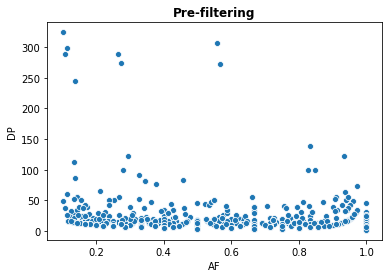

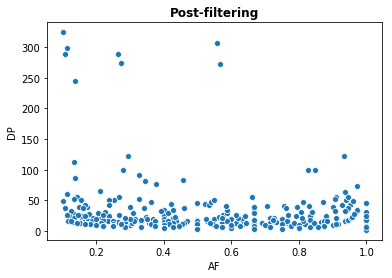

In [9]:
sns.scatterplot(df['AF'].astype('float'), df['DP'].astype('float'))
plt.title('Pre-filtering', fontweight='bold', fontsize=12)
plt.show()
sns.scatterplot(df_filtered['AF'].astype('float'), df_filtered['DP'].astype('float'))
plt.title('Post-filtering', fontweight='bold', fontsize=12)
plt.show()

### Enrichment for lower VAF variants after filtering for non-pathogenic, non-COSMIC, but present in population DB variants

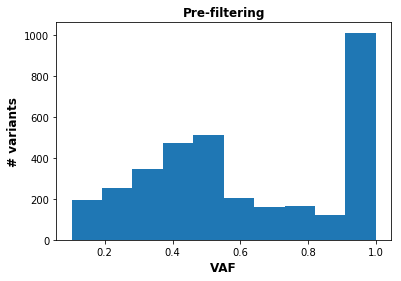

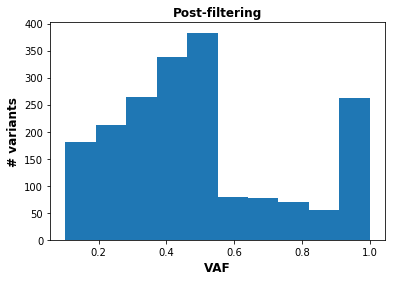

In [10]:
plt.hist(df['AF'])
plt.title('Pre-filtering', fontweight='bold', fontsize=12)
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('VAF', fontweight='bold', fontsize=12)
plt.show()
plt.hist(df_filtered['AF'])
plt.title('Post-filtering', fontweight='bold', fontsize=12)
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('VAF', fontweight='bold', fontsize=12)
plt.show()

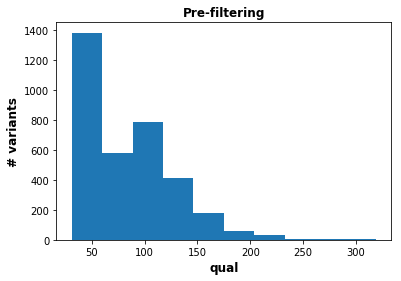

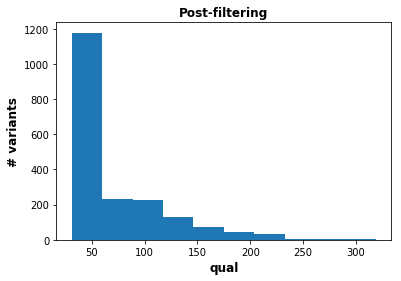

In [11]:
plt.hist(df['qual'].astype('float'))
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('qual', fontweight='bold', fontsize=12)
plt.title('Pre-filtering', fontweight='bold', fontsize=12)
plt.show()
plt.hist(df_filtered['qual'].astype('float'))
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('qual', fontweight='bold', fontsize=12)
plt.title('Post-filtering', fontweight='bold', fontsize=12)
plt.show()

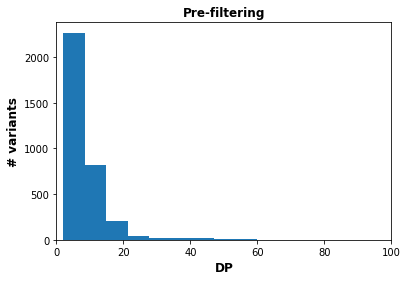

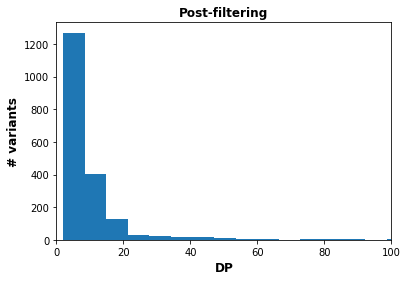

In [12]:
plt.hist(df['DP'].astype('float'), bins=50)
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('DP', fontweight='bold', fontsize=12)
plt.xlim(0,100)
plt.title('Pre-filtering', fontweight='bold', fontsize=12)
plt.show()
plt.hist(df_filtered['DP'].astype('float'), bins=50)
plt.ylabel('# variants', fontweight='bold', fontsize=12)
plt.xlabel('DP', fontweight='bold', fontsize=12)
plt.xlim(0,100)
plt.title('Post-filtering', fontweight='bold', fontsize=12)
plt.show()

In [13]:
info_keys = [i.split('=')[0] for i in df_filtered.loc[0]['info'].split(';')]
info_vals = [i.split('=')[1] for i in df_filtered.loc[0]['info'].split(';')]
dict(zip(info_keys, info_vals))

{'AC': '1',
 'ADJAF': '0',
 'AF': '0.6667',
 'AN': '2',
 'BIAS': '0:2',
 'CALLERS': 'vardict,freebayes',
 'DP': '3',
 'DUPRATE': '0',
 'EPR': 'pass',
 'HIAF': '1',
 'HICNT': '2',
 'HICOV': '2',
 'LSEQ': 'TCTTGCATTGCTGCGACCAG',
 'MQ': '29',
 'MSI': '3',
 'MSILEN': '1',
 'NM': '1.5',
 'ODDRATIO': '0',
 'PMEAN': '13',
 'PSTD': '0',
 'QSTD': '0',
 'QUAL': '45',
 'REFBIAS': '0:0',
 'RSEQ': 'GATCCTCTCTCCATGTCTGT',
 'SAMPLE': 'FFPE_AIO_3ng_A1',
 'SBF': '1',
 'SHIFT3': '0',
 'SN': '4',
 'SPANPAIR': '0',
 'SPLITREAD': '0',
 'TYPE': 'SNV',
 'VARBIAS': '1:1',
 'VD': '2',
 'rs_ids': 'rs34648463',
 'ANN': 'T|intron_variant|MODIFIER|PLCH2|ENSG00000149527|transcript|ENST00000609981|protein_coding|2/3|c.115+9827G>T||||||WARNING_TRANSCRIPT_NO_STOP_CODON'}

In [14]:
df_filtered['COSMIC'] = [True if any('cosmic' in a for a in df_filtered.loc[i]['info'].split(';')) else False for i in df_filtered.index] 

In [15]:
test_filter = df_filtered[df_filtered['qual'].astype('float') > 50]
test_filter = test_filter[test_filter['DP'] >= 10]
test_filter.shape

(369, 14)

# Looking at the FF vcf

In [16]:
df = vcf_to_df_simple.vcf_to_df_simple('../../data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/FRFZ-ensemble-annotated.vcf.gz')
df['DP'] = [int(f.split(':')[1]) for f in df['format']]
df['AF'] = [float(f.split(':')[4]) for f in df['format']]

KeyboardInterrupt: 

## For the fresh frozen VCF, remove the the variant calls that were not called by both vardict and freebayes

In [ ]:
keep_vars = []

for i in df.index:
    var = df.loc[i]
    info = var['info']
    if 'vardict' in info:
        if 'freebayes' in info:
            keep_vars.append(i)

In [ ]:
df = df.loc[keep_vars]

In [ ]:
keep_var = []
remove_var = []

not_path_in_clinvar = ['benign',' not_provided','uncertain','drug_response']

for i in df.index:
    var = df.loc[i]
    info = var['info'].split(';')
    
    if any('EPR' in s for s in info):
        
        # Variant not found in database
        if 'EPR=pass' in info:
            keep_var.append(i)
            continue
        
        # Variant found in COSMIC database
        elif any('cosmic' in s for s in info):
            keep_var.append(i)
            continue
        
        # Variant found at max aaf > 0.01 and not deemed pathogenic in clinvar
        else:
            for s in info:
                if s.startswith('max_aaf_all'):
                    max_aaf_all = float(s.split('=')[-1])
            
            if not max_aaf_all:
                print('SOMETHING WRONG, NO MAX AAF')
                break
            
            if max_aaf_all > 0.001:
                if any('clinvar' in s for s in info):
                    for s in info:
                        if s.startswith('clinvar_sig'):
                            path_label = s.split('=')[-1].lower()
                            if any(path_label in non_path for non_path in not_path_in_clinvar):
                                remove_var.append(i)
                            else:
                                keep_var.append(i)
                else:
                    remove_var.append(iu)
            else:
                keep_var.append(i)
    else:
        keep_var.append(i)
        continue
        

## Perform filtering for all samples

In [2]:
samples = ['FFPE_AIO_3_A1',
           'FFPE_AIO_3_A2',
           'FFPE_AIO_3_A3',
           'FFPE_AIO_3_A4',
           'FFPE_AIO_3_B1',
           'FFPE_AIO_3_B2',
           'FFPE_AIO_3_C1',
           'FFPE_AIO_3_C2',
           'FFPE_AIO_3_S',
           'FFPE_AIO_100_S']

In [94]:
for sample in samples:
    
    df = vcf_to_df_simple.vcf_to_df_simple('../../data/vcf_AIO/exome_ffpe_bcbio/2018-12-15_aio_ffpe_bcbio/{}-vardict.region.filter.vcf.gz'.format(sample))
    
    print('{} has {} mutations.'.format(sample, df.shape[0]))
    
    df['DP'] = [int(f.split(':')[1]) for f in df['format']]
    df['AF'] = [float(f.split(':')[4]) for f in df['format']]
    
    keep_var = []
    remove_var = []

    not_path_in_clinvar = ['benign',' not_provided','uncertain','drug_response']

    for i in df.index:
        var = df.loc[i]
        info = var['info'].split(';')

        if any('EPR' in s for s in info):

            # Variant not found in database
            if 'EPR=pass' in info:
                keep_var.append(i)
                continue

            # Variant found in COSMIC database
            elif any('cosmic' in s for s in info):
                keep_var.append(i)
                continue

            # Variant found at max aaf > 0.01 and not deemed pathogenic in clinvar
            else:
                for s in info:
                    if s.startswith('max_aaf_all'):
                        max_aaf_all = float(s.split('=')[-1])

                if not max_aaf_all:
                    print('SOMETHING WRONG, NO MAX AAF')
                    keep_var.append(i)
                    continue

                if max_aaf_all > 0.001:
                    if any('clinvar' in s for s in info):
                        for s in info:
                            if s.startswith('clinvar_sig'):
                                path_label = s.split('=')[-1].lower()
                                if any(path_label in non_path for non_path in not_path_in_clinvar):
                                    remove_var.append(i)
                                else:
                                    keep_var.append(i)
                    else:
                        remove_var.append(i)
                else:
                    keep_var.append(i)
        else:
            keep_var.append(i)
            continue
        
    df_filtered = df.loc[keep_var]
    df_filtered['COSMIC'] = [True if any('cosmic' in a for a in df_filtered.loc[i]['info'].split(';')) else False for i in df_filtered.index] 
    df_filtered.to_csv('../../data/{}.vardict.filtered.tsv'.format(sample), sep='\t')
    
    df.to_csv('../../data/{}.vardict.tsv'.format(sample), sep='\t')

    print('{} has {} mutations after filtering.\n'.format(sample, df_filtered.shape[0]))

FFPE_AIO_3_A1 has 1542 mutations.
FFPE_AIO_3_A1 has 632 mutations after filtering.

FFPE_AIO_3_A2 has 1398 mutations.
FFPE_AIO_3_A2 has 603 mutations after filtering.

FFPE_AIO_3_A3 has 1767 mutations.
FFPE_AIO_3_A3 has 750 mutations after filtering.

FFPE_AIO_3_A4 has 1566 mutations.
FFPE_AIO_3_A4 has 628 mutations after filtering.

FFPE_AIO_3_B1 has 1910 mutations.
SOMETHING WRONG, NO MAX AAF
FFPE_AIO_3_B1 has 764 mutations after filtering.

FFPE_AIO_3_B2 has 1957 mutations.
FFPE_AIO_3_B2 has 760 mutations after filtering.

FFPE_AIO_3_C1 has 1902 mutations.
FFPE_AIO_3_C1 has 776 mutations after filtering.

FFPE_AIO_3_C2 has 1889 mutations.
FFPE_AIO_3_C2 has 739 mutations after filtering.

FFPE_AIO_3_S has 1883 mutations.
FFPE_AIO_3_S has 759 mutations after filtering.

FFPE_AIO_100_S has 1390 mutations.
FFPE_AIO_100_S has 140 mutations after filtering.



In [99]:
data_dct = {}
lst_ = []
for s in samples:
    data_dct[s] = pd.read_table('../../data/{}.vardict.filtered.tsv'.format(s), sep='\t')
    data_dct[s] = data_dct[s][data_dct[s]['DP'].astype(int) > 5]
    print('{} has {} mutations after filtering for min depth of 5.'.format(s,data_dct[s].shape[0]))
    data_dct[s] = data_dct[s][data_dct[s]['qual'].astype(float) > 50]
    print('{} has {} mutations after filtering for min qual of 50.'.format(s,data_dct[s].shape[0]))
    data_dct[s] = data_dct[s][data_dct[s]['AF'].astype(float) > 0.2]
    print('{} has {} mutations after filtering for min AF of 0.2.'.format(s,data_dct[s].shape[0]))
    data_dct[s] = data_dct[s][data_dct[s]['COSMIC']]
    print('{} has {} mutations in COSMIC.\n'.format(s,data_dct[s].shape[0]))
    
    data_dct[s]['var'] = data_dct[s]['chr'] + ':' \
                        + data_dct[s]['start'].map(str) + '-' \
                        +  data_dct[s]['stop'].map(str) + '_' \
                        +  data_dct[s]['ref'].map(str) + '>' \
                        +  data_dct[s]['alt'].map(str)
    
       
    
    data_dct[s][s] = 1
    
    types = []
    for i in data_dct[s]['info'].str.split(';'):
        for a in i:
            if a.startswith('TYPE'):
                type_ = str(a.split('=')[-1])
        types.append(type_)
    data_dct[s]['type'] = types
    data_dct[s] = data_dct[s][(data_dct[s]['type'] != 'SNV') & (data_dct[s]['type'] != 'snp')]
    print('{} has {} mutations after filtering for mutation type.\n'.format(s,data_dct[s].shape[0]))
    
    lst_.append(data_dct[s][['var',s]])

FFPE_AIO_3_A1 has 601 mutations after filtering for min depth of 5.
FFPE_AIO_3_A1 has 87 mutations after filtering for min qual of 50.
FFPE_AIO_3_A1 has 78 mutations after filtering for min AF of 0.2.
FFPE_AIO_3_A1 has 25 mutations in COSMIC.

FFPE_AIO_3_A1 has 1 mutations after filtering for mutation type.

FFPE_AIO_3_A2 has 554 mutations after filtering for min depth of 5.
FFPE_AIO_3_A2 has 62 mutations after filtering for min qual of 50.
FFPE_AIO_3_A2 has 59 mutations after filtering for min AF of 0.2.
FFPE_AIO_3_A2 has 21 mutations in COSMIC.

FFPE_AIO_3_A2 has 1 mutations after filtering for mutation type.

FFPE_AIO_3_A3 has 721 mutations after filtering for min depth of 5.
FFPE_AIO_3_A3 has 98 mutations after filtering for min qual of 50.
FFPE_AIO_3_A3 has 86 mutations after filtering for min AF of 0.2.
FFPE_AIO_3_A3 has 29 mutations in COSMIC.

FFPE_AIO_3_A3 has 1 mutations after filtering for mutation type.

FFPE_AIO_3_A4 has 594 mutations after filtering for min depth of 5.
FF

In [100]:
a = pd.merge(lst_[0],lst_[1],on='var',how='outer')

for i in range(2,len(lst_)):
    a = pd.merge(a,lst_[i], on='var', how='outer')
a = a.fillna(0)
a.index = a['var']
a = a[a.columns[1:]]

AttributeError: 'AxesSubplot' object has no attribute 'ax_heatmap'

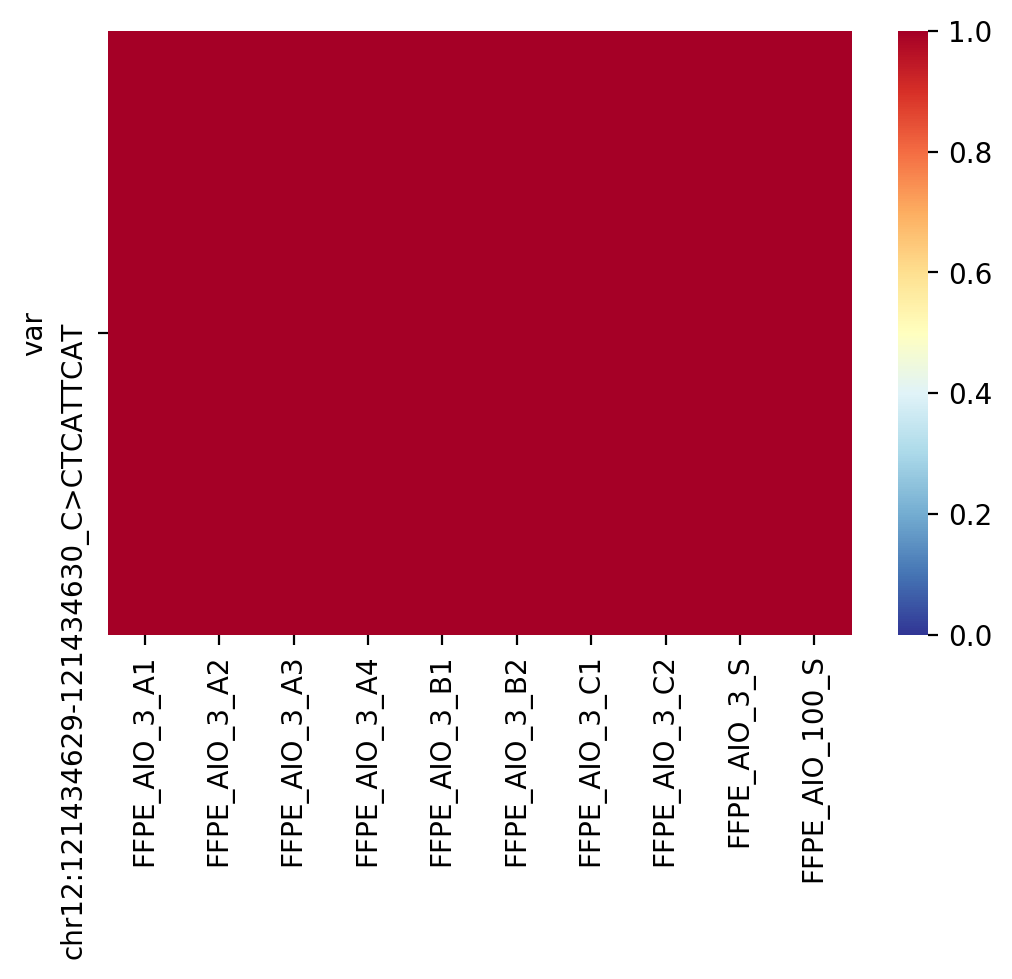

In [111]:
grid = sns.clustermap(a, cmap='RdYlBu_r',annot_kws={"size": 16})
grid.cax.set_visible(False)
plt.setp(grid.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
grid.ax_heatmap.set_ylabel("Variant", fontweight='bold', fontsize=12)
grid.ax_heatmap.set_xlabel("Sample", fontweight='bold', fontsize=12)
grid.ax_heatmap.set_title("COSMIC variants: minimum VAF 0.1",fontweight='bold', fontsize=12)

## Plot clustermaps of filtered FF, and FFPE samples 
> with AIO exome intersect panel

> filtered for depth >5 and qual > 50

In [3]:
samples = ['FRFZ',
           'FFPE_AIO_3_A1',
           'FFPE_AIO_3_A2',
           'FFPE_AIO_3_A3',
           'FFPE_AIO_3_A4',
           'FFPE_AIO_3_B1',
           'FFPE_AIO_3_B2',
           'FFPE_AIO_3_C1',
           'FFPE_AIO_3_C2',
           'FFPE_AIO_3_S',
           'FFPE_AIO_100_S']

In [6]:
for sample in samples:
    
    df = vcf_to_df_simple.vcf_to_df_simple('../../data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/{}-ensemble.region.gmfilter.dp_qualfilter.vcf.gz'.format(sample))
    
    print('{} has {} mutations.\n'.format(sample, df.shape[0]))
    
    df['DP'] = [int(f.split(':')[1]) for f in df['format']]
    df['AF'] = [float(f.split(':')[4]) for f in df['format']]
    
    df['COSMIC'] = [True if any('cosmic' in a for a in df.loc[i]['info'].split(';')) else False for i in df.index] 
    df.to_csv('../../data/{}.ensemble.region.gmfilter.dp_qualfilter.tsv'.format(sample), sep='\t')

FRFZ has 60 mutations.

FFPE_AIO_3_A1 has 40 mutations.

FFPE_AIO_3_A2 has 31 mutations.

FFPE_AIO_3_A3 has 45 mutations.

FFPE_AIO_3_A4 has 40 mutations.

FFPE_AIO_3_B1 has 60 mutations.

FFPE_AIO_3_B2 has 71 mutations.

FFPE_AIO_3_C1 has 49 mutations.

FFPE_AIO_3_C2 has 57 mutations.

FFPE_AIO_3_S has 66 mutations.

FFPE_AIO_100_S has 60 mutations.



In [23]:
data_dct = {}
lst_ = []
for s in samples:
    data_dct[s] = pd.read_table('../../data/{}.ensemble.region.gmfilter.dp_qualfilter.tsv'.format(s), sep='\t')
    data_dct[s] = data_dct[s][data_dct[s]['DP'].astype(int) > 5]
    print('{} has {} mutations after filtering for min depth of 5.'.format(s,data_dct[s].shape[0]))
    data_dct[s] = data_dct[s][data_dct[s]['qual'].astype(float) > 50]
    print('{} has {} mutations after filtering for min qual of 50.'.format(s,data_dct[s].shape[0]))
    data_dct[s] = data_dct[s][data_dct[s]['AF'].astype(float) > 0.1]
    print('{} has {} mutations after filtering for min AF of 0.1.'.format(s,data_dct[s].shape[0]))
#     data_dct[s] = data_dct[s][data_dct[s]['COSMIC']]
#     print('{} has {} mutations in COSMIC.\n'.format(s,data_dct[s].shape[0]))
    
    data_dct[s]['var'] = data_dct[s]['chr'] + ':' \
                        + data_dct[s]['start'].map(str) + '-' \
                        +  data_dct[s]['stop'].map(str) + '_' \
                        +  data_dct[s]['ref'].map(str) + '>' \
                        +  data_dct[s]['alt'].map(str)
    
       
    
    data_dct[s][s] = 1
    
    types = []
    for i in data_dct[s]['info'].str.split(';'):
        for a in i:
            if a.startswith('TYPE'):
                type_ = str(a.split('=')[-1])
        types.append(type_)
    data_dct[s]['type'] = types
    data_dct[s] = data_dct[s][(data_dct[s]['type'] != 'SNV') & (data_dct[s]['type'] != 'snp')]
    print('{} has {} mutations after filtering for mutation type.\n'.format(s,data_dct[s].shape[0]))
    
    lst_.append(data_dct[s][['var',s]])

FRFZ has 60 mutations after filtering for min depth of 5.
FRFZ has 60 mutations after filtering for min qual of 50.
FRFZ has 60 mutations after filtering for min AF of 0.1.
FRFZ has 1 mutations after filtering for mutation type.

FFPE_AIO_3_A1 has 40 mutations after filtering for min depth of 5.
FFPE_AIO_3_A1 has 40 mutations after filtering for min qual of 50.
FFPE_AIO_3_A1 has 40 mutations after filtering for min AF of 0.1.
FFPE_AIO_3_A1 has 3 mutations after filtering for mutation type.

FFPE_AIO_3_A2 has 31 mutations after filtering for min depth of 5.
FFPE_AIO_3_A2 has 31 mutations after filtering for min qual of 50.
FFPE_AIO_3_A2 has 31 mutations after filtering for min AF of 0.1.
FFPE_AIO_3_A2 has 1 mutations after filtering for mutation type.

FFPE_AIO_3_A3 has 45 mutations after filtering for min depth of 5.
FFPE_AIO_3_A3 has 45 mutations after filtering for min qual of 50.
FFPE_AIO_3_A3 has 45 mutations after filtering for min AF of 0.1.
FFPE_AIO_3_A3 has 1 mutations after fi

In [24]:
a = pd.merge(lst_[0],lst_[1],on='var',how='outer')

for i in range(2,len(lst_)):
    a = pd.merge(a,lst_[i], on='var', how='outer')
a = a.fillna(0)
a.index = a['var']
a = a[a.columns[1:]]

Text(0.5, 1.0, 'Somatic indel variants: minimum VAF 0.1')

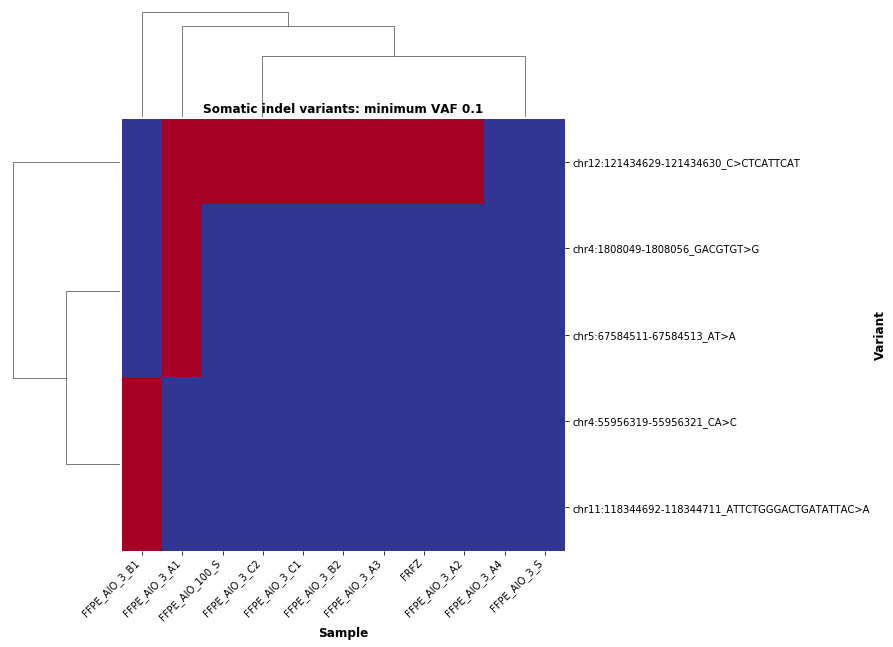

In [28]:
grid = sns.clustermap(a, cmap='RdYlBu_r',annot_kws={"size": 16})
grid.cax.set_visible(False)
plt.setp(grid.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
grid.ax_heatmap.set_ylabel("Variant", fontweight='bold', fontsize=12)
grid.ax_heatmap.set_xlabel("Sample", fontweight='bold', fontsize=12)
grid.ax_heatmap.set_title("Somatic indel variants: minimum VAF 0.1",fontweight='bold', fontsize=12)